In [1]:
# Required imports

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

In [2]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw())

░      ┌───┐ ░    ┌─┐ ░                                     »
  Q: ───────────░───■──┤ H ├─░────┤M├─░─────────────────────────────────────»
     ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░                                     »
  A: ┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─────────────────────────────────────»
     └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ ┌────── ┌───┐ ───────┐ ┌────── ┌───┐»
  B: ─────┤ X ├─░────────────░──╫──╫──░─┤ If-0  ┤ X ├  End-0 ├─┤ If-0  ┤ Z ├»
          └───┘ ░            ░  ║  ║  ░ └──╥─── └───┘ ───────┘ └──╥─── └───┘»
                                ║  ║    ┌──╨──┐                   ║         »
a: 1/═══════════════════════════╩══╬════╡ 0x1 ╞═══════════════════╬═════════»
                                0  ║    └─────┘                ┌──╨──┐      »
b: 1/══════════════════════════════╩═══════════════════════════╡ 0x1 ╞══════»
                                   0                           └─────┘      »
«               
«  Q: ──────────
«               
«  A: ──────────
«      ───────┐ 
«  B:   End-0 ├─
«      ───────┘ 
«a: 1/══════════
«               
«b: 1/══════════
«

In [3]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)

display(random_gate.to_matrix())

array([[0.5665629 +0.j        , 0.41218798+0.71351773j],
       [0.51030181+0.64699191j, 0.20968462-0.52633248j]])

In [4]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q

test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above.

test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure.

test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw())

┌──────────────────────────┐ ░            ░      ┌───┐ ░    ┌─┐ ░ »
       Q: ┤ U(1.9369,0.90297,4.1885) ├─░────────────░───■──┤ H ├─░────┤M├─░─»
          └──────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░ »
       A: ─────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─»
                                       ░ └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ »
       B: ─────────────────────────────░──────┤ X ├─░────────────░──╫──╫──░─»
                                       ░      └───┘ ░            ░  ║  ║  ░ »
     a: 1/══════════════════════════════════════════════════════════╩══╬════»
                                                                    0  ║    »
     b: 1/═════════════════════════════════════════════════════════════╩════»
                                                                       0    »
Result: 1/══════════════════════════════════════════════════════════════════»
                                                                            »
«                                                         ░ »
«       Q: ───────────────────────────────────────────────░─»
«                                                         ░ »
«       A: ───────────────────────────────────────────────░─»
«          ┌────── ┌───┐ ───────┐ ┌────── ┌───┐ ───────┐  ░ »
«       B: ┤ If-0  ┤ X ├  End-0 ├─┤ If-0  ┤ Z ├  End-0 ├──░─»
«          └──╥─── └───┘ ───────┘ └──╥─── └───┘ ───────┘  ░ »
«          ┌──╨──┐                   ║                      »
«     a: 1/╡ 0x1 ╞═══════════════════╬══════════════════════»
«          └─────┘                ┌──╨──┐                   »
«     b: 1/═══════════════════════╡ 0x1 ╞═══════════════════»
«                                 └─────┘                   »
«Result: 1/═════════════════════════════════════════════════»
«                                                           »
«                                            
«       Q: ──────────────────────────────────
«                                            
«       A: ──────────────────────────────────
«          ┌─────────────────────────────┐┌─┐
«       B: ┤ U(-1.9369,-4.1885,-0.90297) ├┤M├
«          └─────────────────────────────┘└╥┘
«     a: 1/════════════════════════════════╬═
«                                          ║ 
«     b: 1/════════════════════════════════╬═
«                                          ║ 
«Result: 1/════════════════════════════════╩═
«                                          0

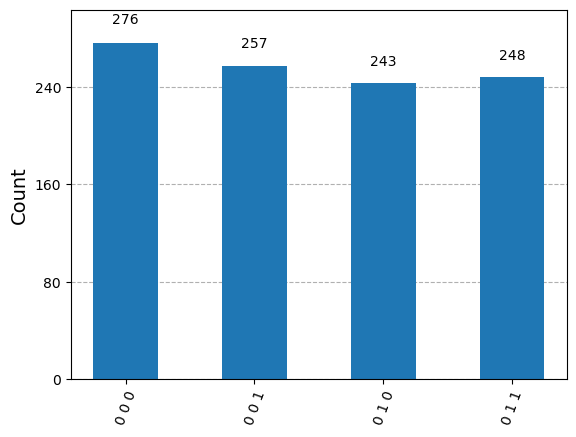

In [5]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

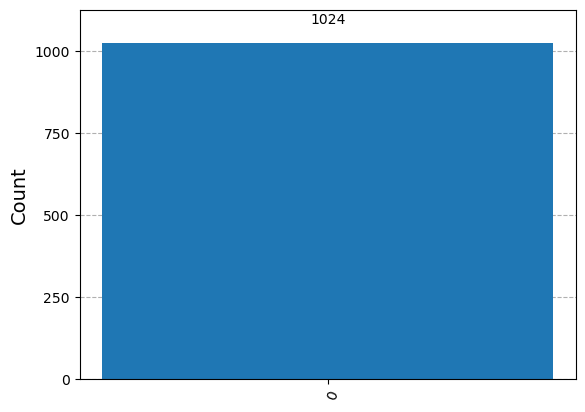

In [6]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))